$$ R_t^{(n)} = \sum_{k=0}^{n-1} \gamma^k R_{t+k+1} $$

$$ L = \left( R_t + \gamma^n \max_{a'} Q(S_{t+n}, a') - Q(S_t, A_t) \right)^2 $$


In [12]:
import gymnasium as gym
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from Algorithms.Agents.BaseAgent import BaseAgent
from tqdm.notebook import tqdm


class NstepAgent(BaseAgent):
    def __init__(self, _env: gym.envs, use_conv=True, _lr=3e-4, _gamma=0.99, _buffer_size=10000, _nsteps=3):
        super().__init__(_env, use_conv, _lr, _gamma, _buffer_size)
        self.nsteps, self.nstep_buffer = _nsteps, []
        self.learn_start = 100 # todo maybe make them attrs of the BaseAgent
        self.update_freq = 1
        
    def append_to_replay(self, s, a, r, s_, te, tr):
        self.nstep_buffer.append((s,a,r,s_))
        if len(self.nstep_buffer) < self.nsteps:
            return
        
        R = sum([self.nstep_buffer[i][2] * (self.gamma ** i) for i in range(self.nsteps)])
        _state, _action, _, _ = self.nstep_buffer.pop(0)
        
        self.replay_buffer.push(_state, _action, R, s_, te, tr)
        
    def update(self, s ,a , r, s_, te, tr):
        self.frame += 1
        self.append_to_replay( s ,a , r, s_, te, tr)
        # todo add clip -1, 1, add learn_start frame
        
        if self.frame < self.learn_start or self.frame % self.update_freq != 0:
            return None
        _batch = self.replay_buffer.sample(self.batch_size)
        _loss = self.compute_loss(_batch)

        self.optimizer.zero_grad()
        _loss.backward()
        self.optimizer.step()
        
        return _loss
        
    def finish_nstep(self):
        while len(self.nstep_buffer) > 0:
            R = sum([self.nstep_buffer[i][2]*(self.gamma**i) for i in range(len(self.nstep_buffer))])
            _state, _action, _, _ = self.nstep_buffer.pop(0)

            self.replay_buffer.push((_state, _action, R, None))

In [4]:
env = gym.make('CartPole-v1')

episode_reward = 0
batch_size = 32
max_episodes = 400
max_steps = 1000

# Initialize your DQN model
agent = NstepAgent(env, use_conv=False)

episode_rewards, episode_losses = [], []
best_reward, best_model_path = -float('inf'), 'best_model.pth'

for episode in tqdm(range(max_episodes), desc='Training'):
    episode_reward, episode_loss = 0, 0
    state = env.reset()[0]
    state = th.tensor(state, dtype=th.float32).to(agent.device)

    for step in range(max_steps):
        action = agent.get_action(state)
        next_state, reward, term, trunc, _ = env.step(action)
        next_state = th.tensor(next_state, dtype=th.float32).to(agent.device)
        agent.replay_buffer.push(state, action, reward, next_state, term, trunc)

        episode_reward += reward

        loss = agent.update(state, action, reward, next_state, term, trunc)

        if loss is not None: episode_loss += loss.item()
            
        if term or trunc:
            episode_rewards.append(episode_reward)
            episode_losses.append(episode_loss)
            if episode % 100 == 0: print(f"Episode {episode}: rew->{episode_reward}\t")
            break
            
        if episode_reward > best_reward:
            best_reward = episode_reward
            th.save(agent.net.state_dict(), best_model_path)

        state = next_state

/home/kostiskak/anaconda3/envs/ai_env/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Episode 0: rew->17.0	
Episode 100: rew->500.0	
Episode 200: rew->163.0	
Episode 300: rew->500.0	


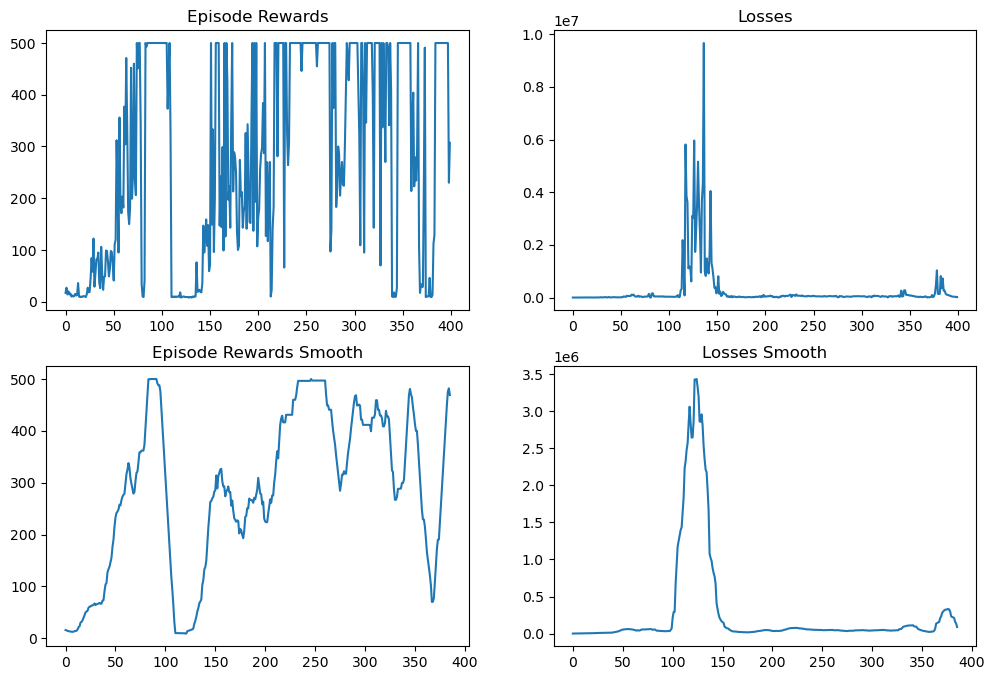

In [6]:
mv_avg = lambda arr, win: np.convolve(arr, np.ones(win)/win, mode='valid')
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(mv_avg(episode_rewards, 1))
plt.title("Episode Rewards")
plt.subplot(2, 2, 2)
plt.plot(mv_avg(episode_losses, 1))
plt.title("Losses")
plt.subplot(2, 2, 3)
plt.plot(mv_avg(episode_rewards, 15))
plt.title("Episode Rewards Smooth")
plt.subplot(2, 2, 4)
plt.plot(mv_avg(episode_losses, 15))
plt.title("Losses Smooth")

plt.show()


### Plot conclusions: 
We can see two things:
1. Whenever the reward is small (either in the beginning or in the explanation stage) the loss is higher, meaning that the network is learning.
2. Even when the reward is high the loss is non-zero, because even if the max reward is achieved the network is still learning.

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a trained DQN model `agent.model`
# and you know the ranges for each state variable in CartPole

# Sample states (example for position and velocity)
positions = np.linspace(-4.8, 4.8, 100)  # Adjust as per actual range
velocities = np.linspace(-50, 50, 100)  # Adjust as per actual range
actions = [0, 1]  # Possible actions in CartPole

best_model = BaseAgent(env, use_conv=False, _model_path=best_model_path, eval_mode=True)
best_model.load()
best_model.net(state)


for pos in positions:
    for vel in velocities:
        state = np.array([pos, 0, vel, 0])  # Example state
        state_tensor = th.tensor(state, dtype=th.float32).unsqueeze(0).to('cuda')
        q_values = agent.net(state_tensor).detach().cpu().numpy().flatten()
        
        # Plotting
        plt.plot(actions, q_values, label=f'Pos: {pos}, Vel: {vel}')

plt.xlabel('Actions')
plt.ylabel('Q-values')
plt.legend()
plt.show()



KeyboardInterrupt



# Load the best model has failed

In [13]:
agent = BaseAgent(env, use_conv=False, eval_mode=True)
agent.load()
agent.net(state)

episode_rewards, episode_losses = [], []
best_reward, best_model_path = -float('inf'), 'best_model.pth'

for episode in tqdm(range(max_episodes), desc='Training'):
    episode_reward, episode_loss = 0, 0
    state = env.reset()[0]
    state = th.tensor(state, dtype=th.float32).to(agent.device)

    for step in range(max_steps):
        action = agent.get_action(state)
        next_state, reward, term, trunc, _ = env.step(action)
        next_state = th.tensor(next_state, dtype=th.float32).to(agent.device)
        agent.replay_buffer.push(state, action, reward, next_state, term, trunc)

        episode_reward += reward

        loss = agent.update(state, action, reward, next_state, term, trunc)

        if loss is not None: episode_loss += loss.item()
            
        if term or trunc:
            episode_rewards.append(episode_reward)
            episode_losses.append(episode_loss)
            if episode % 100 == 0: print(f"Episode {episode}: rew->{episode_reward}\t")
            break
            
        if episode_reward > best_reward:
            best_reward = episode_reward
            th.save(agent.net.state_dict(), best_model_path)

        state = next_state

TypeError: BaseAgent.__init__() got an unexpected keyword argument 'eval_mode'